In [122]:
!pip install torch torchaudio soundfile seaborn seaborn_image lightning fvcore tensorboard -q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


## Data load

In [25]:
import os
import torch
import torchaudio

import numpy as np
import pandas as pd
import seaborn as sns
import seaborn_image as isns
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from torchaudio.datasets import SPEECHCOMMANDS


data = SPEECHCOMMANDS(root="data", download=True)
path = 'data/SpeechCommands/speech_commands_v0.02/visual/0d6d7360_nohash_2.wav'
signal, sr = torchaudio.load(path)

signal.shape, signal

(torch.Size([1, 16000]),
 tensor([[ 0.0003, -0.0003,  0.0002,  ...,  0.0006,  0.0006,  0.0006]]))

<Axes: >

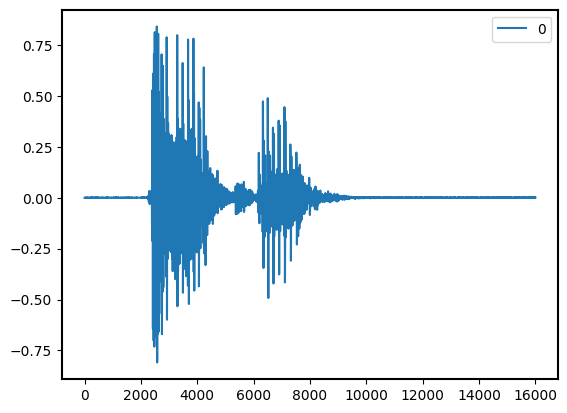

In [3]:
sns.lineplot(data[1][0].t())

As we can see, each data sample is a waveform

## LogMelFilterBanks

In [4]:
from typing import Optional

from torch import nn
from torchaudio import functional as F



class LogMelFilterBanks(nn.Module):
    def __init__(
            self,
            n_fft: int = 400,
            samplerate: int = 16000,
            hop_length: int = 160,
            n_mels: int = 80,
            pad_mode: str = 'reflect',
            power: float = 2.0,
            normalize_stft: bool = False,
            onesided: bool = True,
            center: bool = True,
            return_complex: bool = True,
            f_min_hz: float = 0.0,
            f_max_hz: Optional[float] = None,
            norm_mel: Optional[str] = None,
            mel_scale: str = 'htk',
            device: torch.device = torch.device("cpu")
    ):
        super(LogMelFilterBanks, self).__init__()
        self.device = device
        # general params and params defined by the exercise
        self.n_fft = n_fft
        self.samplerate = samplerate
        self.window_length = n_fft
        self.window = torch.hann_window(self.window_length).to(self.device)
        # Do correct initialization of stft params below:
        # hop_length, n_mels, center, return_complex, onesided, normalize_stft, pad_mode, power
        # ...
        # <YOUR CODE GOES HERE>
        self.hop_length = hop_length if hop_length is not None else self.window_length // 2
        self.n_mels = n_mels
        self.center = center
        self.return_complex = return_complex
        self.onesided = onesided
        self.normalize_stft = normalize_stft
        self.pad_mode = pad_mode
        self.power = power
        # Do correct initialization of mel fbanks params below:
        # f_min_hz, f_max_hz, norm_mel, mel_scale
        self.f_min_hz = f_min_hz
        self.f_max_hz = f_max_hz if f_max_hz else float(self.samplerate // 2.0)
        self.norm_mel = norm_mel if norm_mel else "slaney"
        self.mel_scale = mel_scale
        self.mel_fbanks = self._init_melscale_fbanks()

    def _init_melscale_fbanks(self):
        # To access attributes, use self.<parameter_name>
        return F.melscale_fbanks(
            n_freqs=int(self.n_fft // 2 + 1),
            f_min=self.f_min_hz,
            f_max=self.f_max_hz,
            n_mels=self.n_mels,
            sample_rate=self.samplerate,
            mel_scale=self.mel_scale
        )

    def spectrogram(self, waveform: torch.Tensor):
        # x - is an input signal
        return torch.stft(
            input=waveform,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.window_length,
            window=self.window,
            pad_mode=self.pad_mode,
            center=self.center,
            normalized=self.normalize_stft,
            onesided=self.onesided,
            return_complex=self.return_complex,
        )

    def forward(self, waveform: torch.Tensor):
        """
        Args:
            x (Torch.Tensor): Tensor of audio of dimension (batch, time), audiosignal
        Returns:
            Torch.Tensor: Tensor of log mel filterbanks of dimension (batch, n_mels, n_frames),
                where n_frames is a function of the window_length, hop_length and length of audio
        """
        specgram = self.spectrogram(waveform.to(self.device))
        specgram = specgram.abs().pow(self.power)

        mel_specgram = specgram.transpose(-1, -2) @ self.mel_fbanks.to(self.device)
        log_mel_specgram = torch.log(mel_specgram + 1e-6)

        return log_mel_specgram.transpose(1, 2)

In [5]:
melspec = torchaudio.transforms.MelSpectrogram(hop_length=160, n_mels=80)(signal)
logmelbanks = LogMelFilterBanks(device="cpu")(signal)

assert torch.log(melspec + 1e-6).shape == logmelbanks.shape
assert torch.allclose(torch.log(melspec + 1e-6), logmelbanks.cpu())

In [6]:
logmelbanks.shape

torch.Size([1, 80, 101])

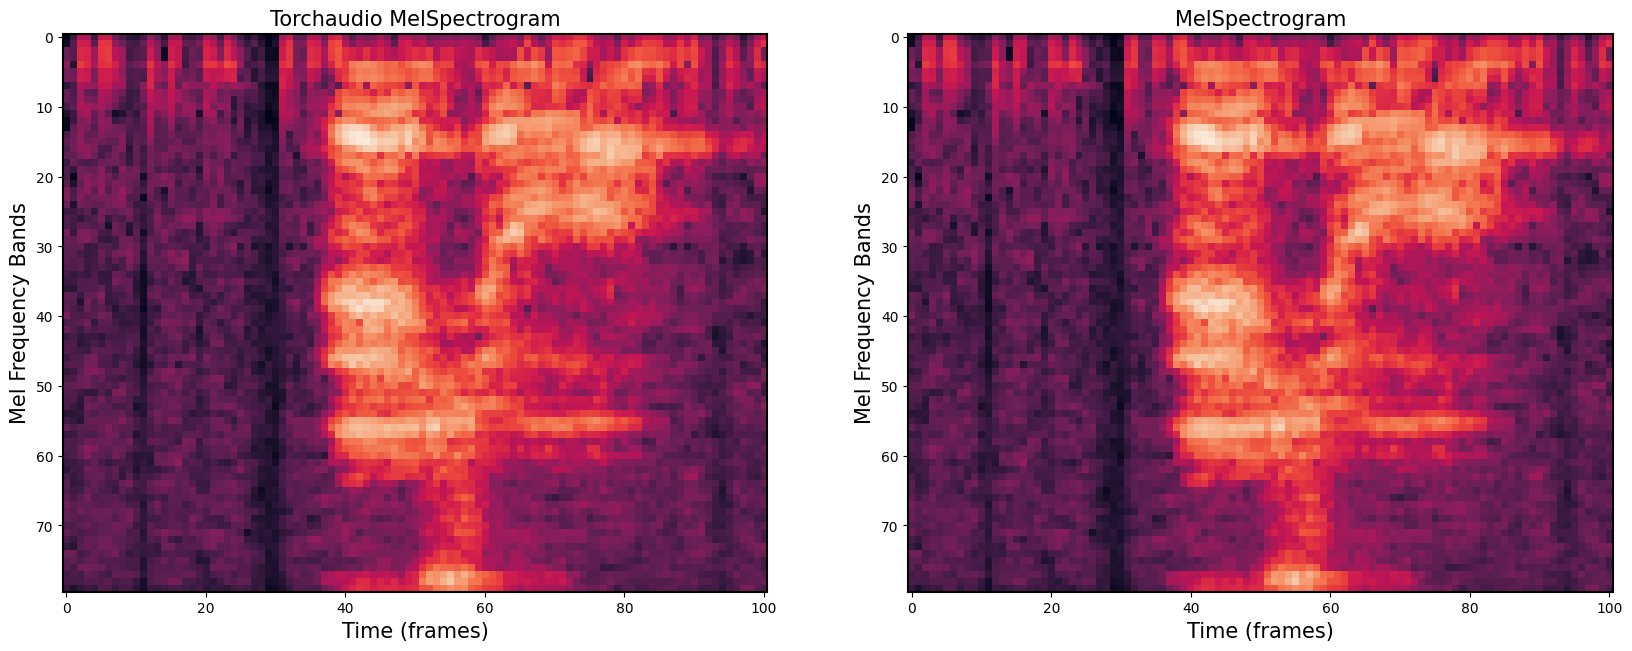

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].set_title('Torchaudio MelSpectrogram')
axes[0].imshow(torch.log(melspec[0] + 1e-6).cpu().numpy(), cmap='rocket')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Mel Frequency Bands')

axes[1].set_title('MelSpectrogram')
axes[1].imshow(logmelbanks[0].cpu().numpy(), cmap='rocket')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Mel Frequency Bands')

fig.show()

The spectrograms are identical

## Dataset preparation

In [8]:
train = SPEECHCOMMANDS(root="data", subset="training")
val = SPEECHCOMMANDS(root="data", subset="validation")
test = SPEECHCOMMANDS(root="data", subset="testing")

train = [train_sample for train_sample in train if train_sample[2] in ["yes", "no"]]
val = [val_sample for val_sample in val if val_sample[2] in ["yes", "no"]]
test = [test_sample for test_sample in test if test_sample[2] in ["yes", "no"]]


len(train), len(val), len(test)

(6358, 803, 824)

In [9]:
def collate_fn(batch):
    waveforms, labels = [], []

    for waveform, label in batch:
        waveforms += [waveform]
        labels += [torch.tensor(label)]

    tensors = [waveform.t() for waveform in waveforms]
    padded_tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True, padding_value=0.)
    labels = torch.stack(labels)

    return padded_tensors, labels

In [10]:
from torch.utils.data import DataLoader, random_split, Dataset


class SpeechDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.label_map = {"yes": 0, "no": 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        waveform, _, label, _, _ = self.data[idx]
        waveform = waveform.squeeze(0)
        label = self.label_map[label]

        return waveform, label


train_dataset = SpeechDataset(train)
val_dataset = SpeechDataset(val)
test_dataset = SpeechDataset(test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [11]:
signal = train_dataset[3][0]
signal = signal.unsqueeze(0)

signal.shape

torch.Size([1, 16000])

In [12]:
logmel = LogMelFilterBanks(device=device)(signal)

logmel.shape

torch.Size([1, 80, 101])

## model configuration

In [79]:
import time
import pytorch_lightning as pl

from torchmetrics.functional import accuracy
from fvcore.nn import FlopCountAnalysis



class CNN(nn.Module):
    def __init__(self, n_mels: int, num_classes: int, groups: int = 2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=n_mels, out_channels=32, kernel_size=3, groups=groups),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, groups=groups),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),

            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, groups=groups),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),

            nn.Flatten(),
            nn.Linear(40, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x


class ClassifierModel(pl.LightningModule):
    def __init__(self, n_mels: int, num_classes: int, groups: int = 2, learning_rate: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.feature_extractor = LogMelFilterBanks(device=device, n_mels=n_mels)
        self.model = CNN(n_mels=n_mels, num_classes=num_classes, groups=groups)
        self.criterion = nn.CrossEntropyLoss()

    def on_train_epoch_start(self):
        self.train_epoch_start_time = time.time()

    def on_train_epoch_end(self):
        epoch_time = time.time() - self.train_epoch_start_time
        self.log("epoch_time", epoch_time)

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.model(features)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)

        acc = accuracy(preds, y, task="multiclass", num_classes=self.hparams.num_classes)
        self.log("val_loss", loss)
        self.log("val_acc", acc)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)

        acc = accuracy(preds, y, task="multiclass", num_classes=self.hparams.num_classes)
        self.log("test_acc", acc)
        self.compute_flops()

        return acc

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=10,
            eta_min=1e-6
        )
        return [optimizer], [scheduler]

    def compute_flops(self, input_size: tuple = (1, 16000)):
        dummy_input = torch.randn(*input_size)
        features = model.feature_extractor(dummy_input.to('cuda:0'))

        flops = FlopCountAnalysis(model.model, features).total()
        self.log("flops", flops)

## n_mels experiments

In [94]:
from lightning.pytorch.loggers import TensorBoardLogger
from tensorboard.backend.event_processing import event_accumulator


n_mels_values = [20, 40, 60, 80, 120]
train_loss_stats = []
test_acc_stats = []

for i, n_mels in enumerate(n_mels_values):
    model = ClassifierModel(n_mels=n_mels, num_classes=2, learning_rate=3e-4)
    logger = TensorBoardLogger(save_dir=os.getcwd(), version=i, name="lightning_logs")

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu",
        logger=logger
    )

    trainer.fit(model, train_loader, val_loader)
    test_acc = trainer.test(dataloaders=test_loader)[0]['test_acc']
    test_acc_stats.append(test_acc)

    log_dir = logger.log_dir

    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    epoch_time_values = [event.value for event in ea.Scalars("epoch_time")]
    print(f"avg epoch time: {np.mean(epoch_time_values)}")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | model             | CNN               | 2.2 K  | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_0/checkpoints/epoch=9-step=1990-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_0/checkpoints/epoch=9-step=1990-v7.ckpt
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Testing: |          | 0/? [00:00<?, ?it/s]

Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d en

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          flops                  183632.0
        test_acc             0.969660222530365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
avg epoch time: 1.3472756326198578


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_1/checkpoints/epoch=9-step=1990-v8.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_1/checkpoints/epoch=9-step=1990-v8.ckpt
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Testing: |          | 0/? [00:00<?, ?it/s]

Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d en

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          flops                  278672.0
        test_acc            0.9720873832702637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
avg epoch time: 1.3686761670642429


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_2/checkpoints/epoch=9-step=1990-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_2/checkpoints/epoch=9-step=1990-v7.ckpt
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Testing: |          | 0/? [00:00<?, ?it/s]

Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d en

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          flops                  373712.0
        test_acc             0.958737850189209
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
avg epoch time: 1.3599490493535995


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_3/checkpoints/epoch=9-step=1990-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_3/checkpoints/epoch=9-step=1990-v6.ckpt
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Testing: |          | 0/? [00:00<?, ?it/s]

Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d en

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          flops                  468752.0
        test_acc            0.9672330021858215
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
avg epoch time: 1.3095192977360317


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_4/checkpoints/epoch=9-step=1990-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_4/checkpoints/epoch=9-step=1990-v6.ckpt
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Testing: |          | 0/? [00:00<?, ?it/s]

Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d en

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          flops                  658832.0
        test_acc            0.9526699185371399
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
avg epoch time: 1.378239165033613


### n_mels vs test_acc

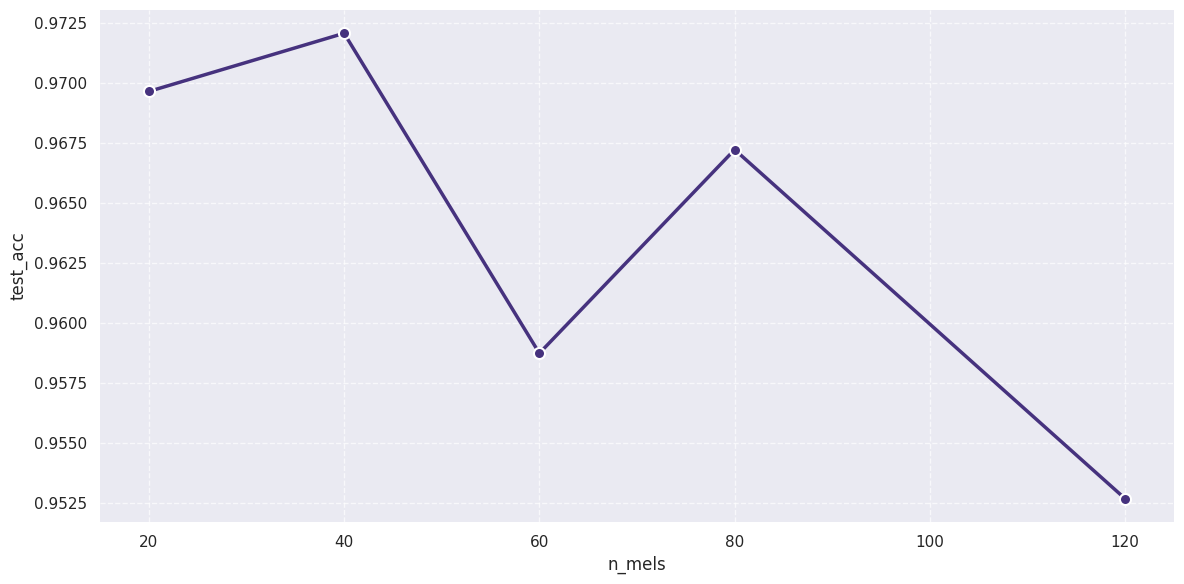

In [95]:
def plot_graph(x: list[int | float], y: list[int | float], x_label: str, y_label: str) -> None:
    sns.set_theme(style="darkgrid", palette="viridis", context='notebook')
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        data=pd.DataFrame({x_label: x, y_label: y}),
        x=x_label,
        y=y_label,
        marker='o',
        markersize=8,
        linewidth=2.5,
        linestyle='-',
        markeredgecolor='w',
        markeredgewidth=1.5
    )

    plt.grid(True, linestyle='--', alpha=0.7)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

plot_graph(x=n_mels_values, y=test_acc_stats, x_label="n_mels", y_label="test_acc")

The most optimal value for n_mels is 60

## groups experiments

In [96]:
def count_parameters(model) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [97]:
groups_values = [1, 2, 4]
flops = []
params = []
test_acc_stats = []
epoch_time_stats = []

for i, groups in enumerate(groups_values):
    model = ClassifierModel(n_mels=40, num_classes=2, groups=groups, learning_rate=3e-4)
    logger = TensorBoardLogger(save_dir=os.getcwd(), version=i, name="lightning_logs")

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu",
        logger=logger
    )

    trainer.fit(model, train_loader, val_loader)
    test_acc = trainer.test(dataloaders=test_loader)[0]['test_acc']
    test_acc_stats.append(test_acc)

    log_dir = logger.log_dir

    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    avg_epoch_time = np.mean([event.value for event in ea.Scalars("epoch_time")])
    flops.append([event.value for event in ea.Scalars('flops')][0])
    params.append(count_parameters(model))
    epoch_time_stats.append(avg_epoch_time)

    print(f"avg epoch time: {avg_epoch_time}")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | model             | CNN               | 7.9 K  | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_0/checkpoints/epoch=9-step=1990-v8.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_0/checkpoints/epoch=9-step=1990-v8.ckpt
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Testing: |          | 0/? [00:00<?, ?it/s]

Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d en

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          flops                  737552.0
        test_acc            0.9769417643547058
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
avg epoch time: 1.3395502302381728


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_1/checkpoints/epoch=9-step=1990-v9.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_1/checkpoints/epoch=9-step=1990-v9.ckpt
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Testing: |          | 0/? [00:00<?, ?it/s]

Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d en

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          flops                  373712.0
        test_acc            0.9635922312736511
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
avg epoch time: 1.3634797525405884


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_2/checkpoints/epoch=9-step=1990-v8.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workdir/search-ml-airflow-29/dags/suggests/llm/sp/lightning_logs/version_2/checkpoints/epoch=9-step=1990-v8.ckpt
/home/mlcore/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Testing: |          | 0/? [00:00<?, ?it/s]

Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d encountered 2 time(s)
Unsupported operator aten::max_pool1d en

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          flops                  191792.0
        test_acc            0.9368932247161865
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
avg epoch time: 1.3579005532794528


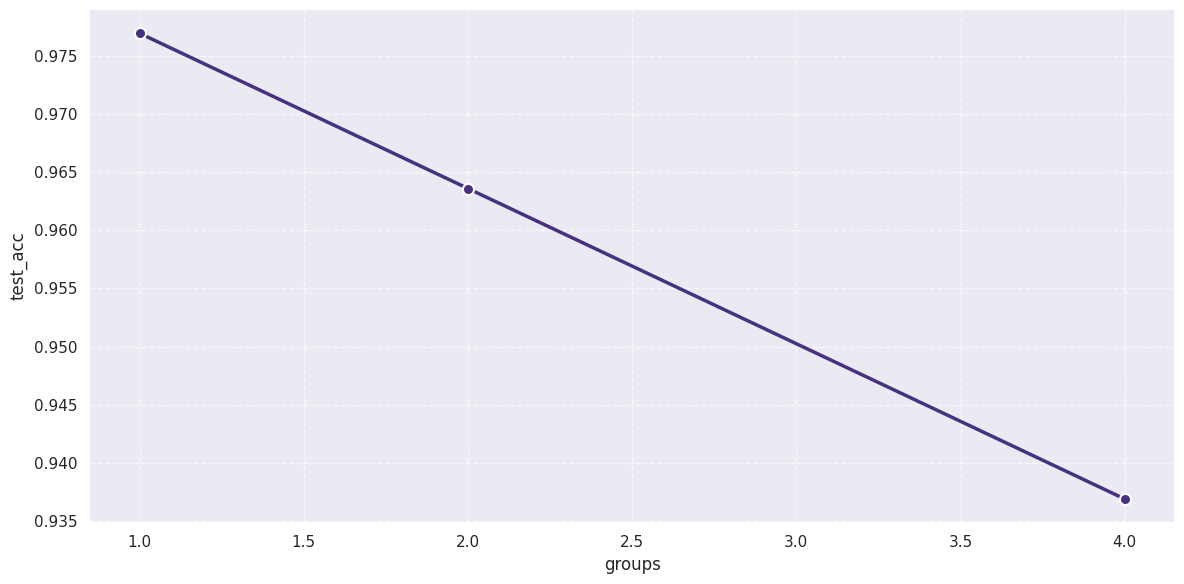

In [109]:
plot_graph(x=groups_values, y=test_acc_stats, x_label="groups", y_label="test_acc")

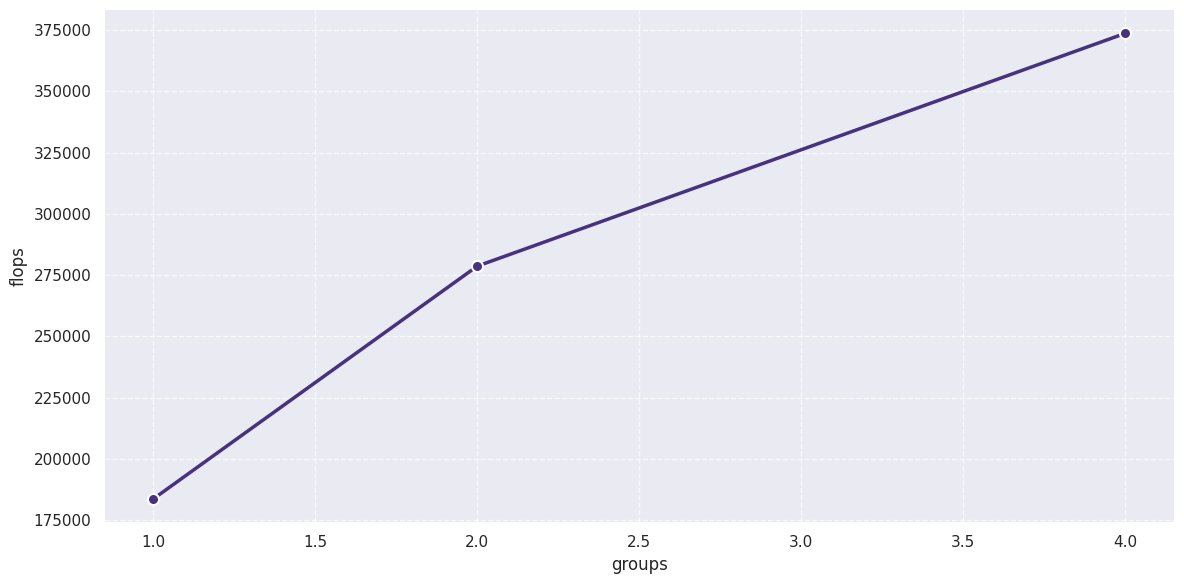

In [110]:
plot_graph(x=groups_values, y=flops, x_label="groups", y_label="flops")

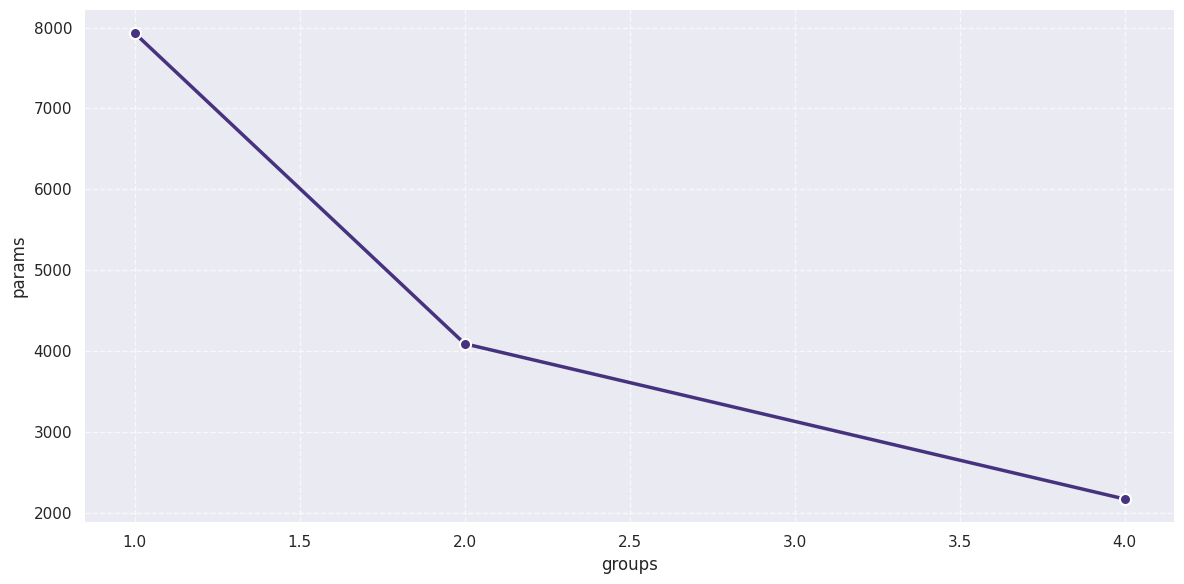

In [111]:
plot_graph(x=groups_values, y=params, x_label="groups", y_label="params")

### Conclusions

* The groups = 1 parameter, where inputs are convolved to all outputs gives the best accuracy on test
* Increasing number of groups parameter directly correlated with number of flops, but number of parameters of the model is decreased